<a target="_blank" href="https://colab.research.google.com/github/NX-AI/tirex/blob/main/examples/quick_start_tirex.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Quick Start In Colab"/>
</a>

### Install TiRex package

In [1]:
!pip install 'tirex-ts[notebooks,gluonts,hfdataset]' -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.2 MB/s eta 0:00:00


### Imports and Load Data

In [14]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd
import torch

from tirex import ForecastModel, load_model
from tirex.util import plot_forecast


In [3]:
data_base_url = "https://raw.githubusercontent.com/NX-AI/tirex/refs/heads/main/tests/data/"
data_air = pd.read_csv(f"{data_base_url}/air_passengers.csv").values.reshape(-1)
data_loop = pd.read_csv(f"{data_base_url}/loop_seattle_5T.csv").values.reshape(-1)

### Load Model

In [4]:
model: ForecastModel = load_model("NX-AI/TiRex")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.ckpt:   0%|          | 0.00/141M [00:00<?, ?B/s]

In [11]:
# dir(model)

In [10]:
# 2. Define a container to hold the embeddings
# This dictionary will store the activations when the model runs
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # output shape is typically: (Batch_Size, Number_of_Patches, Hidden_Dimension)
        activations[name] = output.detach().cpu()
    return hook

# 3. Register the hook on the normalization layer
# 'out_norm' is the layer just before the final prediction head
handle = model.out_norm.register_forward_hook(get_activation('embedding'))

# 4. Run a dummy forecast to trigger the hook
# We use prediction_length=1 because we only care about the context encoding
dummy_context = torch.rand(10, 512)  # Example: 10 time series, length 512
_ = model.forecast(context=dummy_context, prediction_length=1)

# 5. Extract the specific vector
# The model processes data in "patches". We want the state corresponding
# to the MOST RECENT history, which is the last patch.
raw_embeddings = activations['embedding']  # Shape: (10, Num_Patches, Hidden_Dim)
final_embeddings = raw_embeddings[:, -1, :] # Shape: (10, Hidden_Dim)

print(f"Extracted Embedding Shape: {final_embeddings.shape}")

# 6. Cleanup (Good practice)
handle.remove()

Extracted Embedding Shape: torch.Size([10, 512])


In [6]:
print(data_air.shape)

(143,)


In [5]:
def get_activation(name):
    def hook(model, input, output):
        # output shape is typically: (Batch_Size, Number_of_Patches, Hidden_Dimension)
        activations[name] = output.detach().cpu()
    return hook

In [9]:
activations = {}
handle = model.out_norm.register_forward_hook(get_activation('embedding'))
_ = model.forecast(context=data_air, prediction_length=1)
raw_embeddings = activations['embedding']
X_air = raw_embeddings[:, -1, :] # Shape: (10, Hidden_Dim)

X_air.shape

torch.Size([1, 512])

In [10]:
activations = {}
handle = model.out_norm.register_forward_hook(get_activation('embedding'))
_ = model.forecast(context=data_loop, prediction_length=1)
raw_embeddings = activations['embedding']
X_loop = raw_embeddings[:, -1, :] # Shape: (10, Hidden_Dim)

X_loop.shape

torch.Size([1, 512])

In [12]:
X_all = torch.cat([X_air, X_loop], dim=0).numpy()
X_all.shape

(2, 512)

In [18]:
X_inflated = np.tile(X_all, (20, 1))

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


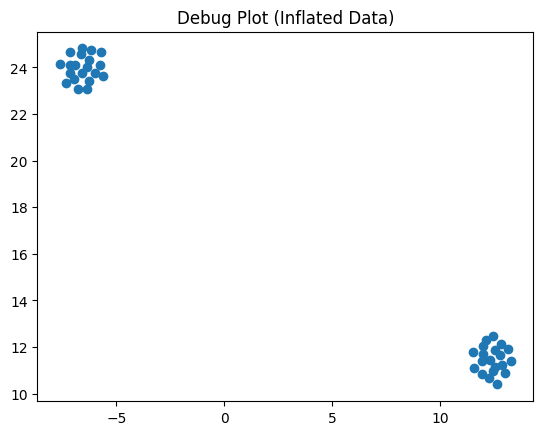

In [19]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(X_inflated)

# 3. Plot
import matplotlib.pyplot as plt
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])
plt.title("Debug Plot (Inflated Data)")
plt.show()

### Generate Forecast

<Axes: >

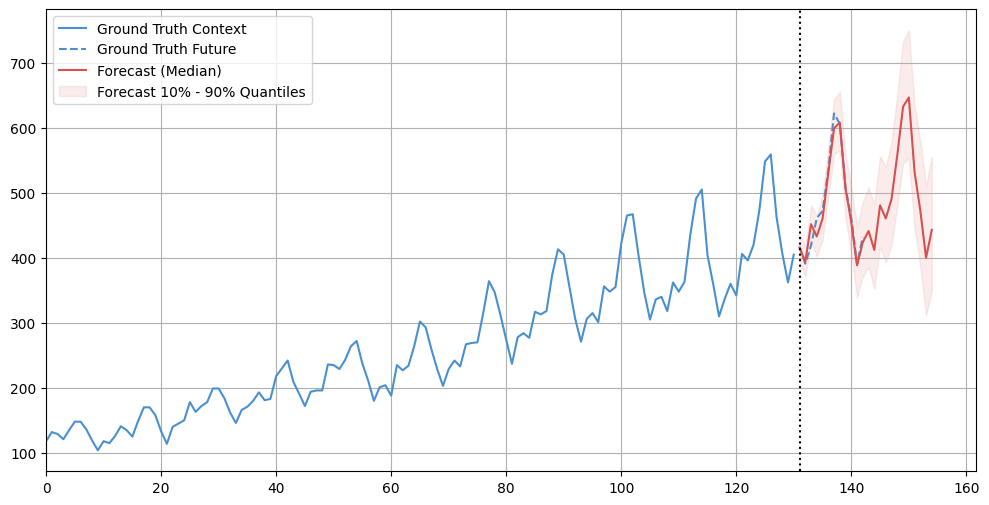

In [ ]:
# Short Horizon - Example
ctx_s, future_s = np.split(data_short, [-12])
quantiles, mean = model.forecast(ctx_s, prediction_length=24)
plot_forecast(ctx_s, quantiles[0], future_s)

<Axes: >

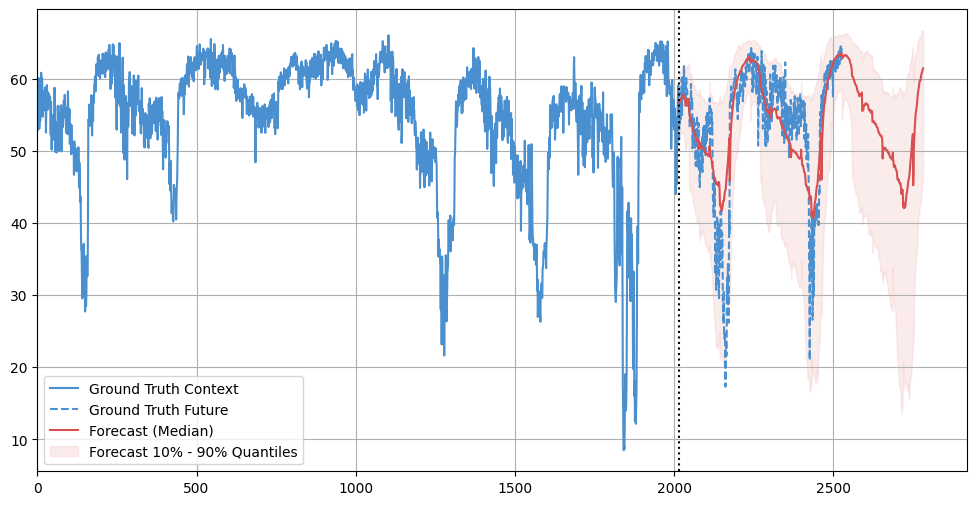

In [ ]:
# Long Horizon - Example
ctx_l, future_l = np.split(data_long, [-512])
quantiles, mean = model.forecast(ctx_l, prediction_length=768)
plot_forecast(ctx_l, quantiles[0], future_l)

### Input Options

TiRex supports forecasting with different input types

In [ ]:
data = torch.tensor(data_short)

# Torch tensor (2D or 1D)
quantiles, means = model.forecast(context=data, prediction_length=24)
print("Predictions (Torch tensor):\n", type(quantiles), quantiles.shape)

# List of Torch tensors (List of 1D) - will be padded
list_torch_data = [data, data, data]
quantiles, means = model.forecast(context=list_torch_data, prediction_length=24, batch_size=2)
print("Predictions (List of Torch tensors):\n", type(quantiles), quantiles.shape)

# NumPy array (2D or 1D)
quantiles, means = model.forecast(context=data.numpy(), prediction_length=24, output_type="torch")
print("Predictions (NumPy):\n", type(quantiles), quantiles.shape)


# List of NumPy arrays (List of 1D) - will be padded
list_numpy_data = [data.numpy()]  # Split into 3 sequences
quantiles, means = model.forecast(context=list_numpy_data, prediction_length=24)
print("Predictions (List of NumPy arrays):\n", type(quantiles), quantiles.shape)


# GluonTS Dataset
try:
    from typing import cast

    from gluonts.dataset import Dataset

    gluon_dataset = cast(Dataset, [{"target": data, "item_id": 1}, {"target": data, "item_id": 22}])
    quantiles, means = model.forecast_gluon(gluon_dataset, prediction_length=24)
    print("Predictions GluonDataset:\n", type(quantiles), quantiles.shape)
    # If you use also `glutonts` as your output type the start_time and item_id get preserved accordingly
    predictions_gluon = model.forecast_gluon(gluon_dataset, prediction_length=24, output_type="gluonts")
    print("Predictions GluonDataset:\n", type(predictions_gluon), type(predictions_gluon[0]))
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]
    pass

Predictions (Torch tensor):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of Torch tensors):
 <class 'torch.Tensor'> torch.Size([3, 24, 9])
Predictions (NumPy):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions (List of NumPy arrays):
 <class 'torch.Tensor'> torch.Size([1, 24, 9])


/opt/homebrew/Caskroom/miniconda/base/envs/tirex-plot/lib/python3.13/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Predictions GluonDataset:
 <class 'torch.Tensor'> torch.Size([2, 24, 9])
Predictions GluonDataset:
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


### Output Options


TiRex supports different output types for the forecasts

Predictions:
 <class 'torch.Tensor'> torch.Size([1, 24, 9])
Predictions:
 <class 'numpy.ndarray'> (1, 24, 9)
Predictions batch 0:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 1:
 <class 'torch.Tensor'> torch.Size([2, 32, 9])
Predictions batch 2:
 <class 'torch.Tensor'> torch.Size([1, 32, 9])
Predictions (GluonTS Quantile Forecast):
 <class 'list'> <class 'gluonts.model.forecast.QuantileForecast'>


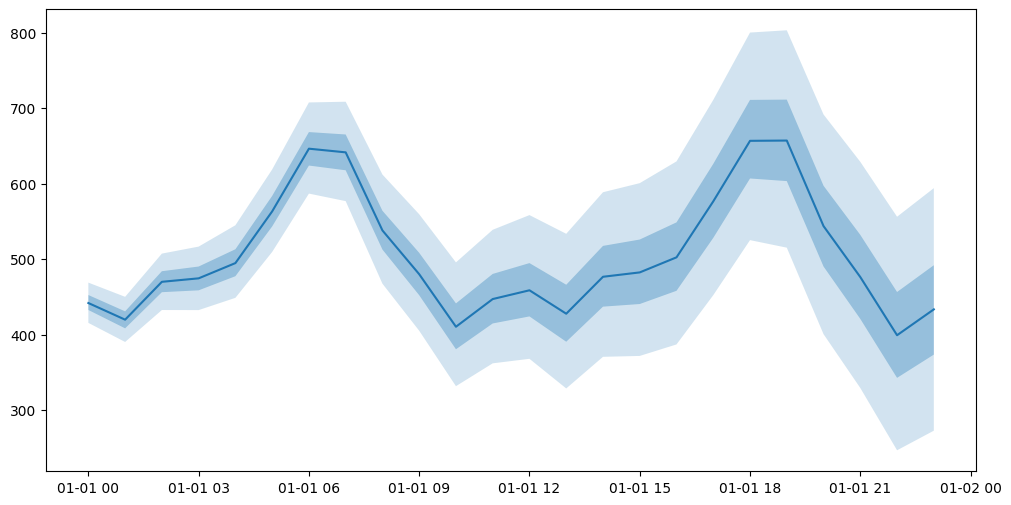

In [ ]:
data = torch.tensor(data_short)

# Default: 2D Torch tensor
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="torch")
print("Predictions:\n", type(quantiles), quantiles.shape)


# 2D Numpy Array
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="numpy")
print("Predictions:\n", type(quantiles), quantiles.shape)


# Iterate by patch
# You can also use the forecast function as iterable. This might help with big datasets. All output_types are supported
for i, fc_batch in enumerate(
    model.forecast(context=[data, data, data, data, data], batch_size=2, output_type="torch", yield_per_batch=True)
):
    quantiles, means = fc_batch
    print(f"Predictions batch {i}:\n", type(quantiles), quantiles.shape)


try:
    # QuantileForecast (GluonTS)
    predictions_gluonts = model.forecast(context=data, prediction_length=24, output_type="gluonts")
    print("Predictions (GluonTS Quantile Forecast):\n", type(predictions_gluon), type(predictions_gluon[0]))
    predictions_gluonts[0].plot()
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]

## Torch compile
Use `compile=True` to speed up the sLSTM layers when using the torch backend.

In [ ]:
model: ForecastModel = load_model("NX-AI/TiRex", backend="torch", device="cuda", compile=True)